In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from IPython.display import display

import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import itertools

import MESS
from MESS.util import set_params

## Set some pandas options to show the full rows and columns of a DF
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Where do you want the simulation output to life?
analysis_dir = "/home/isaac/Continuosity/MESS/analysis/"
analysis_dir = analysis_dir + "/full-parameter-estimation/"
if not os.path.exists(analysis_dir):
    os.mkdir(analysis_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ipyclient = ipp.Client(cluster_id="MESS-Rich")
print(len(ipyclient))

40


In [32]:
r = MESS.Region("whole_enchilada")
## Region params
r.set_param("project_dir", analysis_dir)
r.set_param("generations", 0)
r.set_param("community_assembly_model", "neutral")
r.set_param("mutation_rate", 2.2e-8)
r.set_param("alpha", (500, 5000))

## Metacommunity Params
r.set_param("S_m", 500)
r.set_param("J_m", (5e4, 5e6))
r.set_param("speciation_rate", 2)
r.set_param("death_proportion", 0.7)
r.set_param("trait_rate_meta", 2)
r.set_param("ecological_strength", (1, 10))

## Local Params
r.set_param("J", 1000)
r.set_param("m", (0.001, 0.01))
r.set_param("speciation_prob", (0.0001, 0.001))
r.set_param("background_death", 0.25)

r.write_params(full=True, force=True)
#r.run(sims=1000, ipyclient=ipyclient)

In [54]:
sim_df = pd.read_csv("/home/isaac/Continuosity/MESS/analysis/full-parameter-estimation/SIMOUT.txt", sep="\t", header=0)
len(sim_df)

1197

{0.001,
 0.0011,
 0.0012,
 0.0013,
 0.0014,
 0.0015,
 0.0016,
 0.0017,
 0.0018,
 0.0019,
 0.002,
 0.0021,
 0.0022,
 0.0023,
 0.0024,
 0.0025,
 0.0026,
 0.0027,
 0.0028,
 0.0029,
 0.003,
 0.0031,
 0.0032,
 0.0033,
 0.0034,
 0.0035,
 0.0036,
 0.0037,
 0.0038,
 0.0039,
 0.004,
 0.0041,
 0.0042,
 0.0043,
 0.0044,
 0.0045,
 0.0046,
 0.0047,
 0.0048,
 0.0049,
 0.005,
 0.0051,
 0.0052,
 0.0053,
 0.0054,
 0.0055,
 0.0056,
 0.0057,
 0.0058,
 0.0059,
 0.006,
 0.0061,
 0.0062,
 0.0063,
 0.0064,
 0.0065,
 0.0066,
 0.0067,
 0.0068,
 0.0069,
 0.006999999999999999,
 0.0071,
 0.0072,
 0.0073,
 0.0074,
 0.0075,
 0.0076,
 0.0077,
 0.0078,
 0.0079,
 0.008,
 0.0081,
 0.0082,
 0.0083,
 0.0084,
 0.0085,
 0.0086,
 0.0087,
 0.0088,
 0.0089,
 0.009000000000000001,
 0.0091,
 0.0092,
 0.0093,
 0.0094,
 0.0095,
 0.0096,
 0.0097,
 0.0098,
 0.0099,
 0.01}

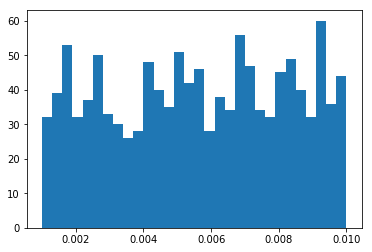

In [66]:
plt.hist(sim_df["m"], bins=30)
#set(sim_df["speciation_prob"])

In [114]:
def get_best_params():
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    ## Randomly search 100 different parameter combinations and take the
    ## one that reduces CV error
    rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),\
                                   param_distributions = random_grid,
                                   n_iter = 100, cv = 3, verbose=0, n_jobs = -1)
    rf_random.fit(Xtrain, ytrain)
    return rf_random.best_estimator_

def plot_cv_pred():
    lims = {"m":0.01, "speciation_prob":0.001}
    for i, p in enumerate(targets):
        fig, ax = plt.subplots()
        vscore = metrics.explained_variance_score(y.iloc[:, i], cv_preds[:, i])
        r2 = metrics.r2_score(y.iloc[:, i], cv_preds[:, i])
        print(p, vscore, r2)
        ax.scatter(y.iloc[:, i], cv_preds[:, i], c='black', marker='.', s=2)
        ax.set_title(p)
        if p in ["m", "speciation_prob"]:
            ax.set_xlim(0, lims[p])
            ax.set_ylim(0, lims[p])

In [110]:
feature_sets = {}
feature_sets["pi"] = [x for x in sim_df.columns if "pi" in x or "SGD" in x]
feature_sets["pi+dxy"] = feature_sets["pi"] + [x for x in sim_df.columns if "dxy" in x]
feature_sets["abund"] = ["S"] + [x for x in sim_df.columns if "abund" in x]
feature_sets["abund+pi"] =  feature_sets["abund"] + feature_sets["pi"]
feature_sets["all"] = sim_df.iloc[:, 22:].columns
feature_sets

{'abund': ['S', 'abund_h1', 'abund_h2', 'abund_h3', 'abund_h4'],
 'abund+ pi': ['S',
  'abund_h1',
  'abund_h2',
  'abund_h3',
  'abund_h4',
  'pi_h1',
  'pi_h2',
  'pi_h3',
  'pi_h4',
  'mean_pi',
  'std_pi',
  'skewness_pi',
  'kurtosis_pi',
  'median_pi',
  'iqr_pi',
  'SGD_0',
  'SGD_1',
  'SGD_2',
  'SGD_3',
  'SGD_4',
  'SGD_5',
  'SGD_6',
  'SGD_7',
  'SGD_8',
  'SGD_9'],
 'all': Index([u'S', u'abund_h1', u'abund_h2', u'abund_h3', u'abund_h4', u'pi_h1', u'pi_h2', u'pi_h3', u'pi_h4', u'mean_pi', u'std_pi', u'skewness_pi', u'kurtosis_pi', u'median_pi', u'iqr_pi', u'mean_dxys', u'std_dxys', u'skewness_dxys', u'kurtosis_dxys', u'median_dxys', u'iqr_dxys', u'trees', u'mean_local_traits', u'std_local_traits', u'skewness_local_traits', u'kurtosis_local_traits', u'median_local_traits', u'iqr_local_traits', u'mean_regional_traits', u'std_regional_traits', u'skewness_regional_traits', u'kurtosis_regional_traits', u'median_regional_traits', u'iqr_regional_traits', u'reg_loc_mean_trait_dif'

abund+ pi
Finding best model params


,abund_h1,kurtosis_pi,skewness_pi,pi_h1,S,SGD_0,abund_h2,pi_h4,abund_h4,pi_h2,pi_h3,abund_h3,iqr_pi,std_pi,SGD_2,SGD_1,SGD_4,SGD_3,mean_pi,SGD_5,SGD_6,SGD_8,median_pi,SGD_7,SGD_9
0,0.088601,0.077386,0.071965,0.065947,0.063065,0.060631,0.055157,0.050997,0.048603,0.047148,0.04665,0.04097,0.036147,0.032101,0.027973,0.027961,0.025769,0.024747,0.022954,0.021252,0.017829,0.01256,0.01193,0.011816,0.009841


('alpha', 0.22630532128697178, 0.2263041772230835)
('J_m', -0.051671953780165536, -0.05167887730474563)
('ecological_strength', -0.017078413073880583, -0.017086952775671183)
('m', 0.5031412048738373, 0.5031098411873827)
('speciation_prob', 0.017486100427002937, 0.017485710427484924)
('_lambda', 0.7814155940781767, 0.7814138153905713)
pi+dxy
Finding best model params


,mean_dxys,median_dxys,kurtosis_dxys,iqr_dxys,std_pi,std_dxys,SGD_0,iqr_pi,skewness_dxys,mean_pi,kurtosis_pi,skewness_pi,median_pi,pi_h1,pi_h4,SGD_1,pi_h3,pi_h2,SGD_3,SGD_2,SGD_5,SGD_4,SGD_6,SGD_9,SGD_7,SGD_8
0,0.695622,0.056273,0.033191,0.026311,0.02031,0.019879,0.018863,0.01655,0.016517,0.013925,0.010836,0.010659,0.007923,0.007209,0.006774,0.005413,0.005343,0.005058,0.004803,0.004794,0.003858,0.003403,0.002117,0.001883,0.001336,0.001152


('alpha', 0.1690019490401522, 0.1689840315440495)
('J_m', 0.6423034189370891, 0.6422917772658696)
('ecological_strength', -0.010587915717007679, -0.01061479383246322)
('m', 0.4110255100645679, 0.41101563627445337)
('speciation_prob', 0.05250179462905147, 0.05249835064112285)
('_lambda', 0.44490839556568773, 0.44490412798139933)
pi
Finding best model params


,kurtosis_pi,skewness_pi,pi_h4,pi_h1,SGD_0,pi_h3,pi_h2,std_pi,iqr_pi,SGD_1,SGD_5,mean_pi,SGD_4,SGD_3,SGD_2,SGD_6,SGD_7,median_pi,SGD_8,SGD_9
0,0.111686,0.102503,0.089954,0.085532,0.084979,0.078373,0.065174,0.048877,0.046135,0.041715,0.038502,0.037311,0.03277,0.030697,0.029145,0.024132,0.015569,0.013149,0.012285,0.011511


('alpha', 0.21117482578548308, 0.2111710192867131)
('J_m', -0.05205397512932164, -0.05205398848804488)
('ecological_strength', -0.0256151810257923, -0.02561621007258741)
('m', 0.5248521231127377, 0.5248183135582294)
('speciation_prob', 0.02176320187474512, 0.021762707719584218)
('_lambda', 0.4912716224522652, 0.49126487921771933)
abund
Finding best model params


,abund_h1,abund_h2,S,abund_h4,abund_h3
0,0.294115,0.236657,0.197496,0.138693,0.133039


('alpha', -0.017051357729323202, -0.017084626997720065)
('J_m', -0.075545138857672, -0.07556494408651027)
('ecological_strength', -0.017843094262687043, -0.017847086632278852)


/home/isaac/miniconda2/envs/MESS/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


('m', 0.5384182108690176, 0.5384154261581229)
('speciation_prob', -0.005510454744613202, -0.005537963738827534)
('_lambda', 0.8790845816041117, 0.8790832089733532)
all
Finding best model params


,mean_dxys,median_dxys,skewness_regional_traits,kurtosis_dxys,kurtosis_regional_traits,iqr_regional_traits,reg_loc_kurtosis_trait_dif,iqr_dxys,std_pi,abund_h4,SGD_0,std_dxys,reg_loc_skewness_trait_dif,skewness_local_traits,reg_loc_median_trait_dif,mean_pi,skewness_dxys,reg_loc_iqr_trait_dif,S,std_regional_traits,reg_loc_std_trait_dif,reg_loc_mean_trait_dif,abund_h3,kurtosis_local_traits,iqr_local_traits,abund_h2,std_local_traits,abund_h1,skewness_pi,mean_regional_traits,median_regional_traits,mean_local_traits,median_local_traits,median_pi,iqr_pi,kurtosis_pi,pi_h1,pi_h4,pi_h2,SGD_2,pi_h3,SGD_1,SGD_5,SGD_3,SGD_9,SGD_4,SGD_6,SGD_7,SGD_8,trees
0,0.6699,0.036724,0.015235,0.014637,0.014161,0.012338,0.012041,0.011273,0.010677,0.010549,0.008663,0.008614,0.008565,0.008492,0.008446,0.008278,0.008193,0.008097,0.008089,0.00754,0.007499,0.007017,0.006966,0.00666,0.006274,0.00594,0.005887,0.005506,0.004918,0.004688,0.004613,0.004521,0.004495,0.004353,0.004315,0.004096,0.002947,0.0024,0.002356,0.002194,0.002037,0.001812,0.001667,0.001587,0.001298,0.001045,0.000991,0.000723,0.000683,0.0


('alpha', 0.10472537661032333, 0.10468107892580514)
('J_m', 0.6440506685357175, 0.6440355186087139)
('ecological_strength', -0.01016626042460711, -0.010171143916148928)
('m', 0.37294625509900103, 0.3729148854405052)
('speciation_prob', 0.04825820419543114, 0.04825439817844157)
('_lambda', 0.5914147610185814, 0.5914034894391667)


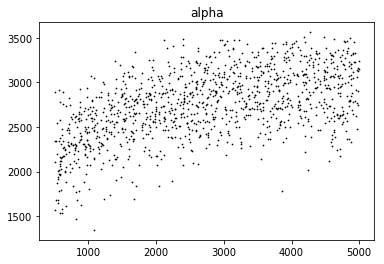

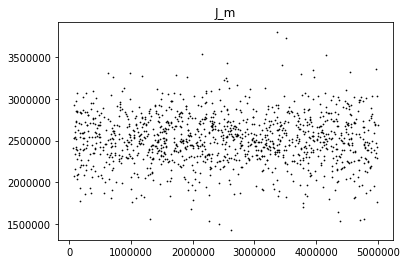

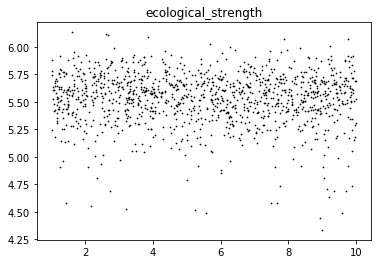

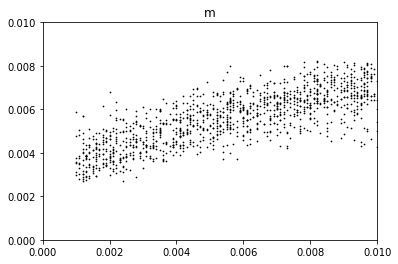

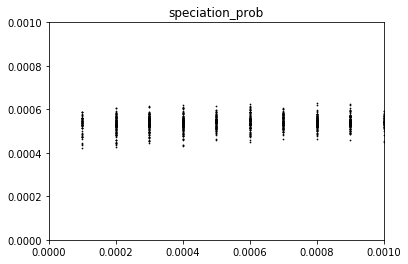

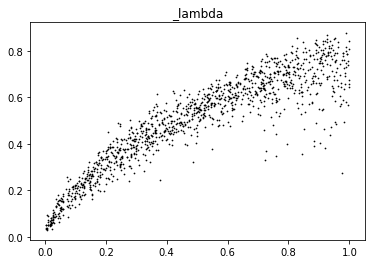

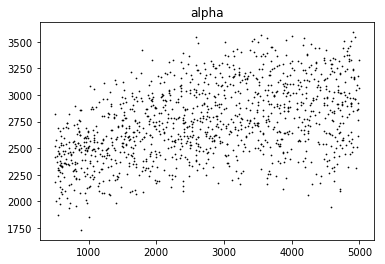

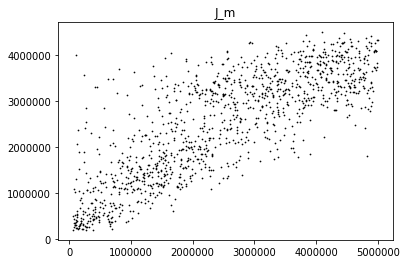

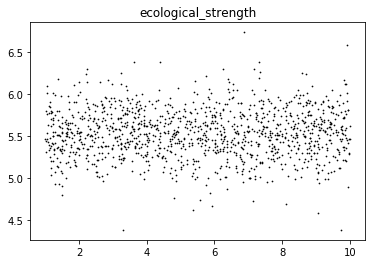

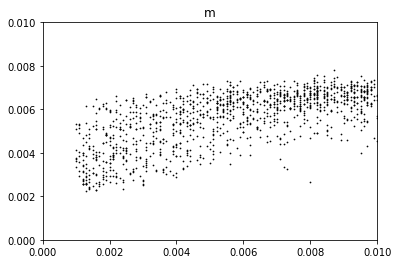

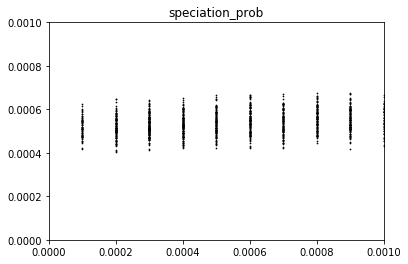

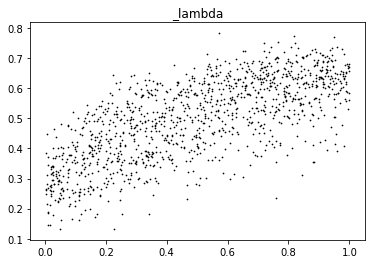

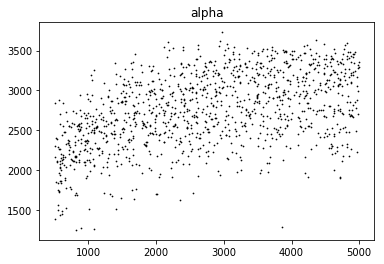

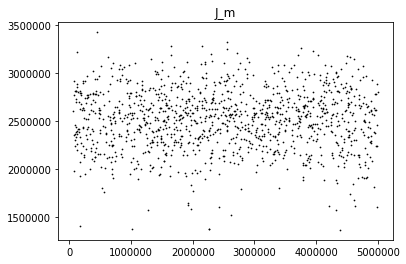

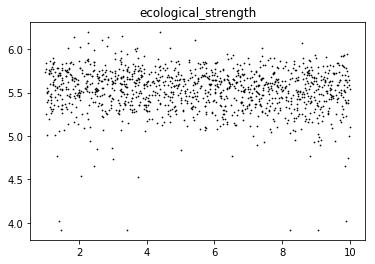

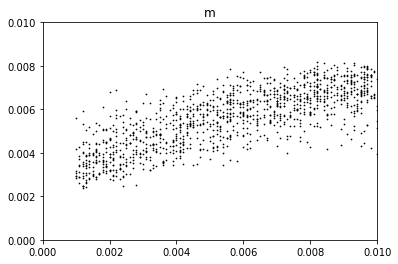

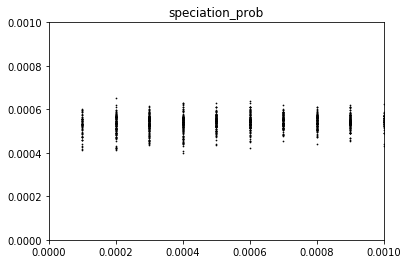

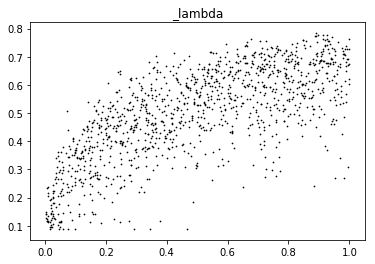

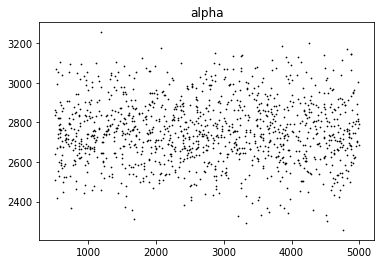

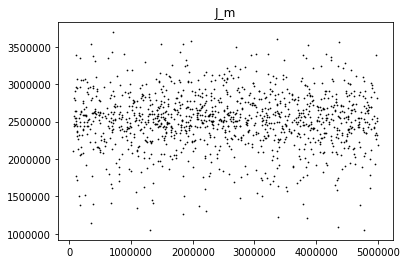

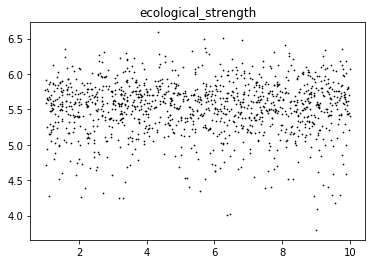

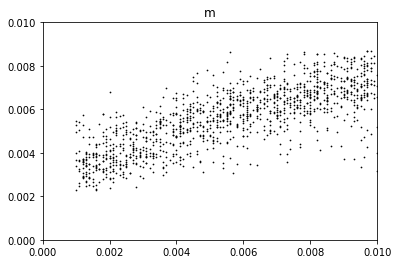

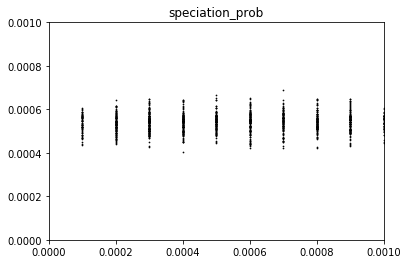

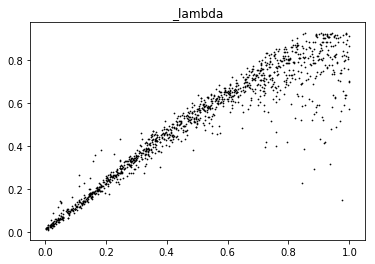

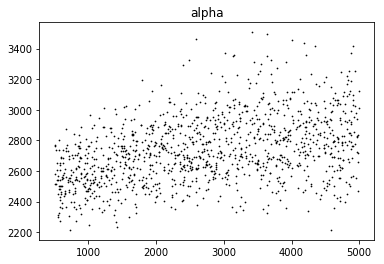

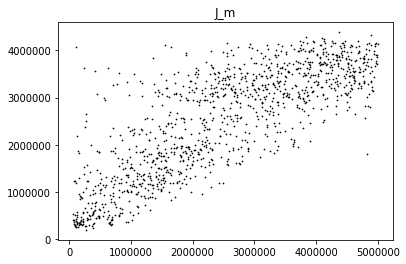

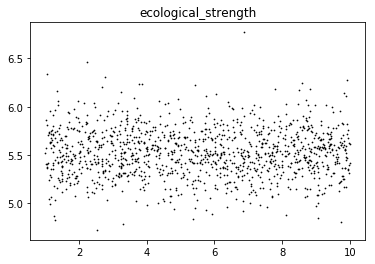

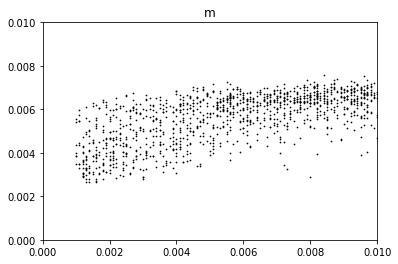

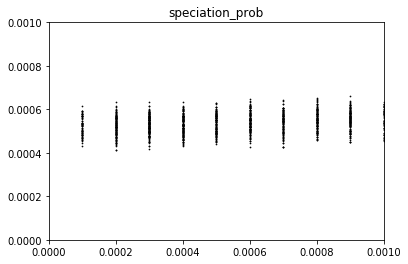

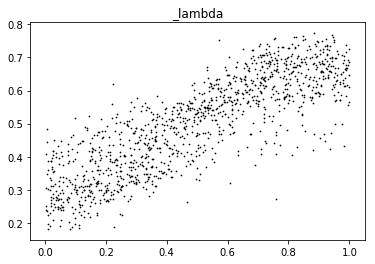

In [115]:
neut_file = "/home/isaac/Continuosity/MESS/analysis/full-parameter-estimation/SIMOUT.txt"
filt_file = "/home/isaac/Continuosity/MESS/analysis/full-parameter-estimation/filt/SIMOUT.txt"
comp_file = "/home/isaac/Continuosity/MESS/analysis/full-parameter-estimation/comp/SIMOUT.txt"

targets = ["alpha", "J_m", "ecological_strength", "m", "speciation_prob", "_lambda"]

## Infile is the input SIMOUT file. model_name is either neutral, comp, or filt
## for labeling the figures
def plot_param_cv(infile, model_name='', nsamps=1e6):
    sim_df = pd.read_csv("/home/isaac/Continuosity/MESS/analysis/full-parameter-estimation/SIMOUT.txt", sep="\t", header=0)
    print(model_name, len(sim_df))
    for f, features in feature_sets.items():
        print(f)
        X = sim_df[features]
        y = sim_df[targets]
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
        print("Finding best model params")
        model = get_best_params()
        display(pd.DataFrame(model.feature_importances_, index=features).sort_values(0, ascending=False).T)
        cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
        plot_cv_pred()
plot_param_cv(infile=neut_file, model_name="neut", nsamps=1e4)

## Dev below here

In [82]:
features = sim_df.iloc[:, 22:].columns

## Parameters to estimate
targets = ["alpha", "J_m", "ecological_strength", "m", "speciation_prob", "_lambda"]

X = sim_df[features]
y = sim_df[targets]

## Split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
display(Xtrain[:5])
display(ytrain[:5])

,S,abund_h1,abund_h2,abund_h3,abund_h4,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,mean_dxys,std_dxys,skewness_dxys,kurtosis_dxys,median_dxys,iqr_dxys,trees,mean_local_traits,std_local_traits,skewness_local_traits,kurtosis_local_traits,median_local_traits,iqr_local_traits,mean_regional_traits,std_regional_traits,skewness_regional_traits,kurtosis_regional_traits,median_regional_traits,iqr_regional_traits,reg_loc_mean_trait_dif,reg_loc_std_trait_dif,reg_loc_skewness_trait_dif,reg_loc_kurtosis_trait_dif,reg_loc_median_trait_dif,reg_loc_iqr_trait_dif,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4,SGD_5,SGD_6,SGD_7,SGD_8,SGD_9
331,22.0,11.5090,9.3053,8.3236,7.7153,3.5717,3.1758,2.8784,2.6800,0.0001,0.0002,2.7467,7.1915,0.0000,0.0000,0.0051,0.0069,2.8625,8.7762,0.0030,0.0056,0.0,-0.9836,3.3354,-0.5613,-0.3924,-1.1075,5.0872,-1.2970,3.5926,-0.1317,-0.3190,-1.1089,4.8567,-0.3134,0.2572,0.4296,0.0734,-0.0013,-0.2304,18.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
933,16.0,5.6307,3.3462,2.6832,2.4251,7.4810,7.0431,6.7023,6.4474,0.0003,0.0003,0.6162,-1.0724,0.0002,0.0004,0.0135,0.0176,1.7014,1.5942,0.0059,0.0164,0.0,-0.8028,3.0603,0.0117,-1.0581,-1.3781,4.4892,-0.7000,2.8862,0.1536,-0.4897,-0.6997,4.1873,0.1027,-0.1741,0.1419,0.5685,0.6784,-0.3019,8.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,2.0
13,28.0,3.4978,1.8125,1.5768,1.4994,6.5585,6.2060,5.9338,5.7249,0.0002,0.0003,1.6307,1.2162,0.0000,0.0001,0.0016,0.0019,1.4657,1.2900,0.0009,0.0020,0.0,-1.1165,2.2590,-0.0438,-0.9734,-1.0809,3.5629,-1.1475,2.6991,0.0852,-0.1759,-1.2075,4.0720,-0.0311,0.4401,0.1289,0.7975,-0.1266,0.5091,21.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,2.0
66,24.0,7.8985,4.6650,3.6942,3.2827,8.6832,6.9159,5.8015,5.1432,0.0004,0.0006,2.2415,5.3539,0.0000,0.0006,0.0020,0.0024,1.3591,0.6399,0.0010,0.0022,0.0,0.3711,5.8165,-0.6095,-0.1919,0.6980,5.3730,-0.5742,6.1348,-0.3725,-0.5866,0.3937,8.7988,-0.9454,0.3183,0.2370,-0.3948,-0.3042,3.4258,13.0,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0
535,7.0,1.3917,1.1461,1.1093,1.0966,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-3.0000,0.0000,0.0000,0.0141,0.0143,1.9241,1.9120,0.0100,0.0047,0.0,-0.3722,2.6683,0.7948,-0.4607,-1.1670,3.0783,-0.3349,3.6320,-0.5066,0.3769,0.1453,4.7499,0.0374,0.9637,-1.3014,0.8376,1.3124,1.6716,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0


,alpha,J_m,ecological_strength,m,speciation_prob,_lambda
331,939,1718863,3.9828,0.0055,0.0008,0.926
933,991,3595529,4.0502,0.0049,0.0002,0.520
13,2326,1312734,5.5901,0.0082,0.0010,0.265
66,2586,1343852,6.6803,0.0051,0.0006,0.607
535,2120,4948555,6.9824,0.0097,0.0009,0.027


In [83]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## Randomly search 100 different parameter combinations and take the
## one that reduces CV error
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),\
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=0, n_jobs = -1)
rf_random.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [101]:
model = rf_random.best_estimator_
ypred = model.predict(Xtest)

#print(model.feature_importances_)
#print(metrics.explained_variance_score(ypred, ytest))
#print(metrics.r2_score(ypred, ytest)) 
pd.DataFrame(model.feature_importances_, index=features).sort_values(0, ascending=False).T

,mean_dxys,median_dxys,kurtosis_dxys,abund_h4,reg_loc_std_trait_dif,iqr_dxys,SGD_0,kurtosis_regional_traits,skewness_regional_traits,reg_loc_kurtosis_trait_dif,std_pi,std_dxys,S,abund_h3,skewness_dxys,iqr_regional_traits,iqr_pi,skewness_local_traits,reg_loc_mean_trait_dif,reg_loc_iqr_trait_dif,reg_loc_median_trait_dif,abund_h2,mean_pi,median_pi,reg_loc_skewness_trait_dif,std_local_traits,kurtosis_local_traits,iqr_local_traits,mean_regional_traits,std_regional_traits,mean_local_traits,median_regional_traits,skewness_pi,median_local_traits,kurtosis_pi,abund_h1,pi_h1,pi_h4,SGD_2,SGD_1,SGD_5,pi_h2,SGD_3,pi_h3,SGD_6,SGD_4,SGD_9,SGD_8,SGD_7,trees
0,0.666214,0.054891,0.015956,0.012981,0.012723,0.012535,0.012061,0.012004,0.011832,0.009544,0.009149,0.008731,0.008397,0.008264,0.008084,0.007885,0.007569,0.00753,0.007518,0.006821,0.006468,0.005836,0.00573,0.005708,0.005618,0.005333,0.005154,0.004911,0.004846,0.004446,0.004382,0.004335,0.004222,0.004135,0.004062,0.004027,0.002484,0.002183,0.002087,0.002069,0.001983,0.00198,0.00161,0.001602,0.001232,0.001121,0.000876,0.000562,0.00031,0.0


In [85]:
scores = cross_val_score(model, X, y, cv=5, n_jobs=-1)
scores

array([0.55567373, 0.64707322, 0.6446963 , 0.67257785, 0.68624674])

In [86]:
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
cv_preds[:2]

array([[2.91124719e+03, 3.25457359e+06, 5.68348536e+00, 4.72666545e-03,
        5.86574948e-04, 5.75507119e-01],
       [3.02390820e+03, 4.05509522e+05, 5.33665951e+00, 6.79118056e-03,
        5.40778478e-04, 3.63868498e-01]])

('alpha', 0.09913367002477425, 0.099107781282053)
('J_m', 0.6436414418725183, 0.6436222030938098)
('ecological_strength', -0.01244018929438706, -0.012453414135890295)
('m', 0.3748076431310253, 0.3747724387196084)
('speciation_prob', 0.04854086005807645, 0.04852659382037261)
('_lambda', 0.5936215006328769, 0.5936147908114506)


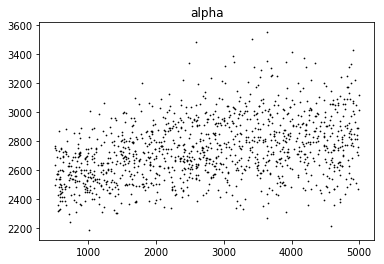

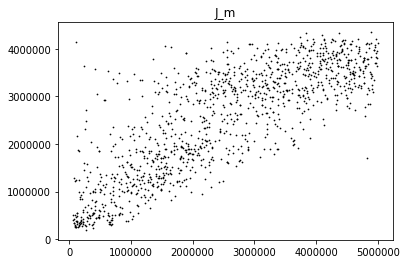

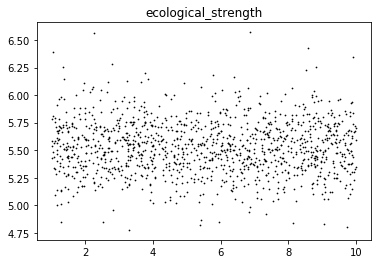

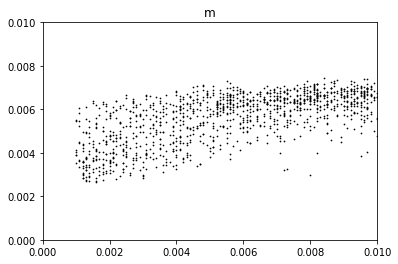

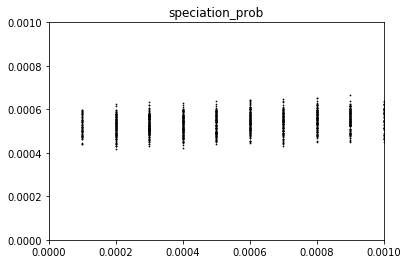

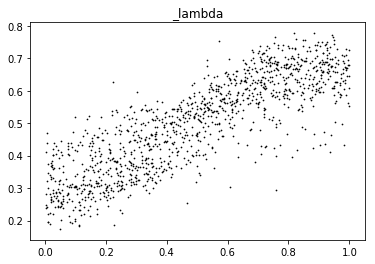

In [92]:
lims = {"m":0.01, "speciation_prob":0.001}
for i, p in enumerate(targets):
    fig, ax = plt.subplots()
    vscore = metrics.explained_variance_score(y.iloc[:, i], cv_preds[:, i])
    r2 = metrics.r2_score(y.iloc[:, i], cv_preds[:, i])
    print(p, vscore, r2)
    ax.scatter(y.iloc[:, i], cv_preds[:, i], c='black', marker='.', s=2)
    ax.set_title(p)
    if p in ["m", "speciation_prob"]:
        ax.set_xlim(0, lims[p])
        ax.set_ylim(0, lims[p])

In [108]:
[x for x in sim_df.columns if "pi" in x or "SGD" in x]

['pi_h1',
 'pi_h2',
 'pi_h3',
 'pi_h4',
 'mean_pi',
 'std_pi',
 'skewness_pi',
 'kurtosis_pi',
 'median_pi',
 'iqr_pi',
 'SGD_0',
 'SGD_1',
 'SGD_2',
 'SGD_3',
 'SGD_4',
 'SGD_5',
 'SGD_6',
 'SGD_7',
 'SGD_8',
 'SGD_9']